# NIH data CNN notebook

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import streamlit as st
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join
import csv

## Train/test split

In [2]:
import CNN.preprocess as pp

In [3]:
pp.train_test_split_images(root_dir: str, training_fraction: float)
pp.train_test_split_labels(root_dir: str, train_set: List[int], test_set: List[int])

Created test and training directories
train_set: 4484 elements
test_set: 1122 elements
parsing csv


# Emphysema detector Network
Let's try a network to detect emphysema cxr's first, baby steps.

We'll make another copy of the `test_nih` and `training_nih` directories and remove all the other conditions from the `labels.csv`

In [5]:
pp.filter_emphysema_rows(join('data', 'sample_labels.csv'), join('data', 'emph_labels.csv'))
pp.filter_emphysema_rows(join('data', 'test_nih', 'labels.csv'), join('data', 'test_nih', 'emph_labels.csv'))
pp.filter_emphysema_rows(join('data', 'training_nih', 'labels.csv'), join('data', 'training_nih', 'emph_labels.csv'))

## Data pre-processing

In [24]:
import os
import glob
from PIL import Image
import numpy as np
from array import array


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath):        
        labels = []
        images = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
        
        return labels

    def read_images(self, images_filepath):        
        labels = []
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)        

## Testing data ingestion methods
Let's decide which of our labels we want to train for first

In [69]:
# Set file paths based on added MNIST Datasets``
input_path = 'data'
training_images_filepath = join(input_path, join('training_nih', 'images'))
training_labels_filepath = join(input_path, join('training_nih', 'emph_labels.csv'))
test_images_filepath = join(input_path, join('test_nih', 'images'))
test_labels_filepath = join(input_path, join('test_nih', 'emph_labels.csv'))

# Load MINST dataset
nih_dataloader = NIHDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)

In [ ]:
images = nih_dataloader.read_images(training_images_filepath)

In [58]:
labels = nih_dataloader.read_labels(training_labels_filepath)

In [62]:
print(f'images[0]: {images[1]}')
print(f'labels[0]: {labels[1]}')

images[0]: [[ 2.  2.  2. ...  1.  1.  1.]
 [ 3.  5.  4. ...  4.  2.  1.]
 [ 2.  5.  5. ...  5.  2.  1.]
 ...
 [ 2.  3.  3. ... 63. 74. 28.]
 [ 2.  3.  3. ... 58. 74. 30.]
 [ 1.  2.  2. ... 27. 36. 15.]]
labels[0]: 1


In [63]:
print(f'type(labels): {type(labels)}')
print(f'type(labels[1]): {type(labels[1])}')
print(f'labels[1]: {labels[1]}')
print(f'len(labels): {len(labels)}')

type(labels): <class 'array.array'>
type(labels[1]): <class 'int'>
labels[1]: 1
len(labels): 4484


## Building CNN model
Helper functions to manage model building, training and training analysis

In [54]:
from keras.optimizers import RMSprop
from sklearn.metrics import precision_score, recall_score, f1_score


def compile_model(learning_rate: float):
    # Setting up the convolution neural network with convnet and maxpooling layer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Model Summary
    print(f'model.summary(): {model.summary()}')

    # Adding the fully connected layers to CNN
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    # Printing model summary
    print(f'model.summary(): {model.summary()}')

    # Create the optimizer with a new learning rate
    optimizer = RMSprop(learning_rate=learning_rate)

    # Configuring the network with the custom optimizer
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    # # Configuring the network
    # model.compile(optimizer='rmsprop(lr=0.0025)',
    #             loss='binary_crossentropy',
    #             metrics=['accuracy'])
    
    return model


def train_model(X_train, Y_train, X_test, Y_test, model, epochs, batch_size):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    return history, precision, recall, f1


## Keras metrics callback 

In [1]:
from tensorflow.keras.callbacks import Callback

class MetricsCallback(Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test

    def on_train_begin(self, logs=None):
        print("Training started...")

    def on_epoch_end(self, epoch, logs=None):
        # Predict on test set
        y_pred = self.model.predict(self.x_test)
        y_pred = (y_pred > 0.5).astype(int)

        # Calculate precision, recall, and F1 score
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)

        # Print the metrics
        print(f"Epoch {epoch+1}/{self.params['epochs']}")
        print(f"loss: {logs['loss']}, accuracy: {logs['accuracy']}, precision: {precision}, recall: {recall}, f1: {f1}")

In [69]:
epochs = 15
batch_size = 32
metrics_callback = MetricsCallback(x_test, y_test)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[metrics_callback])

# history, precision, recall, f1 = train_model(x_train, y_train, x_test, y_test, model, 32, 32)

# print('train model')

MemoryError: Unable to allocate 2.19 GiB for an array with shape (4484, 512, 512) and data type float16

## Data Augmentation
We're getting serious overfitting in the model above, lets take the minority category  in the training dataset and apply rotations, and mirroring. We'll exclude scaling and cropping for now since the images are all pretty tight on the torso.

Here's the data ingestion methods

In [41]:
import os
import glob
from PIL import Image
import numpy as np
from array import array


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath):        
        labels = []
        images = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
        
        return labels

    def read_images(self, images_filepath):        
        labels = []
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
    def augmented_training_images(self, training_filepath: str):
        """
        Function to augment minority category of training data to be of equal size to majority category

        Steps: 
            - ingest training images and labels from new data subdir
            for each image in training set (while len(cat A)<len(cat B))
            - create new unique id
            - write row to label csv
            - apply one of a set of transformations to the new image and save it in image subdir
        """
        # x_train = self.read_images(join(training_filepath, "images"))
        # y_train = self.read_labels(training_filepath)
        # x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
    
        # print(f'x_train: {len(x_train)}')
        print(f'y_train: {len(y_train)}')

        # minority_cat = y_train[y_train[1] == "true"]
        minority_cat = [el for el in y_train if el == 1]
        # majority_cat = y_train[y_train[1] == "false"]
        majority_cat = [el for el in y_train if el == 0]


        print(f'minority_cat: {len(minority_cat)}')
        print(f'majority_cat: {len(majority_cat)}')
        print(f'Need to make {len(majority_cat)/len(minority_cat)} duplicates of each minority case')

        theta = -15
        for image in training_set:
            if len(minority_cat) < len(majority_cat):
                break

            for i in range(48):
                transform, theta = self.return_transform(iter, theta)
                # Iterate over each item in the array
                for call in transform:
                    try:
                        # Execute the function call using exec()
                        _image = exec(call, image)
                    except Exception as e:
                        print('Error executing function:', e)

            # 

    def return_transform(iter, theta):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        if iter%2 == 0:
            theta += 15
        theta %= 360
        transform.append(f"rotate({theta})")

        return transform, theta

    def return_transform(iter, theta):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        theta += 15
        theta %= 360
        transform.append(f"rotate({theta})")

        return transform, theta

            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)        

In [32]:

# Set file paths based on added MNIST Datasets``
input_path = 'data'
training_images_filepath = join(input_path, join('training_nih', 'images'))
training_labels_filepath = join(input_path, join('training_nih', 'emph_labels.csv'))
test_images_filepath = join(input_path, join('test_nih', 'images'))
test_labels_filepath = join(input_path, join('test_nih', 'emph_labels.csv'))

# Load MINST dataset
nih_dataloader = NIHDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
nih_dataloader.augmented_training_images(join('data','training_nih','images'))

y_train: 4484
minority_cat: 94
majority_cat: 4390
Need to make 46.702127659574465 duplicates of each minority case


In [53]:
from IPython.display import clear_output
clear_output(wait=True)

def return_transform(iter, theta):
    transform = []
    if iter%2 == 1:
        transform.append("mirror()")
    if iter%2 == 0:
        theta += 15
    theta %= 360
    transform.append(f"rotate({theta})")

    return transform, theta

theta = -15
for i in range(48):
    transform, theta = return_transform(i, theta)
    print(transform)

['rotate(0)']
['mirror()', 'rotate(0)']
['rotate(15)']
['mirror()', 'rotate(15)']
['rotate(30)']
['mirror()', 'rotate(30)']
['rotate(45)']
['mirror()', 'rotate(45)']
['rotate(60)']
['mirror()', 'rotate(60)']
['rotate(75)']
['mirror()', 'rotate(75)']
['rotate(90)']
['mirror()', 'rotate(90)']
['rotate(105)']
['mirror()', 'rotate(105)']
['rotate(120)']
['mirror()', 'rotate(120)']
['rotate(135)']
['mirror()', 'rotate(135)']
['rotate(150)']
['mirror()', 'rotate(150)']
['rotate(165)']
['mirror()', 'rotate(165)']
['rotate(180)']
['mirror()', 'rotate(180)']
['rotate(195)']
['mirror()', 'rotate(195)']
['rotate(210)']
['mirror()', 'rotate(210)']
['rotate(225)']
['mirror()', 'rotate(225)']
['rotate(240)']
['mirror()', 'rotate(240)']
['rotate(255)']
['mirror()', 'rotate(255)']
['rotate(270)']
['mirror()', 'rotate(270)']
['rotate(285)']
['mirror()', 'rotate(285)']
['rotate(300)']
['mirror()', 'rotate(300)']
['rotate(315)']
['mirror()', 'rotate(315)']
['rotate(330)']
['mirror()', 'rotate(330)']
['ro

## Rotate and translate functions

In [ ]:
labels = []
images = []
                
# Get the list of image file paths in the directory
image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

# Iterate over each image path
for image_path in image_paths:
    image = Image.open(image_path)
    resized_image = image.resize((512, 512))
    grayscale_image = resized_image.convert("L")
    # array = np.array(grayscale_image).astype(float)
    array = np.array(grayscale_image).astype(np.float16)

    images.append(array)


Ingest data and map labels to categorical data format

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
from array import array


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath):        
        labels = []
        images = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
        
        return labels

    def read_images(self, images_filepath):        
        labels = []
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
    def augmented_training_images(self, training_filepath: str):
        """
        Function to augment minority category of training data to be of equal size to majority category

        Steps: 
            - ingest training images and labels from new data subdir
            for each image in training set (while len(cat A)<len(cat B))
            - create new unique id
            - write row to label csv
            - apply one of a set of transformations to the new image and save it in image subdir
        """
        # x_train = self.read_images(join(training_filepath, "images"))
        # y_train = self.read_labels(training_filepath)
        # x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
    
        # print(f'x_train: {len(x_train)}')
        print(f'y_train: {len(y_train)}')

        # minority_cat = y_train[y_train[1] == "true"]
        minority_cat = [el for el in y_train if el == 1]
        # majority_cat = y_train[y_train[1] == "false"]
        majority_cat = [el for el in y_train if el == 0]


        print(f'minority_cat: {len(minority_cat)}')
        print(f'majority_cat: {len(majority_cat)}')
        print(f'Need to make {len(majority_cat)/len(minority_cat)} duplicates of each minority case')

        transformations = {
            'rot_1': rotate(270),
            'mirror': mirror()
        
        }
        while len(minority_cat) < len(majority_cat):
            self.return_transform(iter)

        #     if len(minority_cat) < len(majority_cat):
        #         break
        #     # generate a new image id that does not exist in training dataset
        #     new_id = random_id_not_in_images()
            
        #     # make a copy of the current image row in csv with the new id
        #     write_row_to_csv()

            

        #     # 

    def return_transform(iter):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        theta += 15
        transform.append(f"rotate({theta})")

        return transform

            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)        

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
from array import array


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath):        
        labels = []
        images = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
        
        return labels

    def read_images(self, images_filepath):        
        labels = []
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
    def augmented_training_images(self, training_filepath: str):
        """
        Function to augment minority category of training data to be of equal size to majority category

        Steps: 
            - ingest training images and labels from new data subdir
            for each image in training set (while len(cat A)<len(cat B))
            - create new unique id
            - write row to label csv
            - apply one of a set of transformations to the new image and save it in image subdir
        """
        # x_train = self.read_images(join(training_filepath, "images"))
        # y_train = self.read_labels(training_filepath)
        # x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
    
        # print(f'x_train: {len(x_train)}')
        print(f'y_train: {len(y_train)}')

        # minority_cat = y_train[y_train[1] == "true"]
        minority_cat = [el for el in y_train if el == 1]
        # majority_cat = y_train[y_train[1] == "false"]
        majority_cat = [el for el in y_train if el == 0]


        print(f'minority_cat: {len(minority_cat)}')
        print(f'majority_cat: {len(majority_cat)}')
        print(f'Need to make {len(majority_cat)/len(minority_cat)} duplicates of each minority case')

        transformations = {
            'rot_1': rotate(270),
            'mirror': mirror()
        
        }
        while len(minority_cat) < len(majority_cat):
            self.return_transform(iter)

        #     if len(minority_cat) < len(majority_cat):
        #         break
        #     # generate a new image id that does not exist in training dataset
        #     new_id = random_id_not_in_images()
            
        #     # make a copy of the current image row in csv with the new id
        #     write_row_to_csv()

            

        #     # 

    def return_transform(iter):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        theta += 15
        transform.append(f"rotate({theta})")

        return transform

            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)        

In [27]:
(x_train, y_train), (x_test, y_test) = nih_dataloader.load_data()
print('loaded data')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('mapped y data to categorical')

loaded data
mapped y data to categorical


In [28]:
print(f'x_train: {x_train[0]}')
print(f'y_train: {y_train[0]}')
print(f'x_test: {x_test[0]}')
print(f'y_test: {y_test[0]}')

x_train: [[ 85.  85.  84. ...   5.   5.   5.]
 [ 84.  84.  83. ...   5.   5.   5.]
 [ 80.  79.  79. ...   5.   5.   5.]
 ...
 [120. 122. 131. ...   7.   2.   2.]
 [115. 119. 129. ...   5.   3.   4.]
 [ 40.  41.  43. ...   3.   3.   3.]]
y_train: [1. 0.]
x_test: [[ 85.  85.  84. ...   5.   5.   5.]
 [ 84.  84.  83. ...   5.   5.   5.]
 [ 80.  79.  79. ...   5.   5.   5.]
 ...
 [120. 122. 131. ...   7.   2.   2.]
 [115. 119. 129. ...   5.   3.   4.]
 [ 40.  41.  43. ...   3.   3.   3.]]
y_test: [1. 0.]


In [46]:
model = compile_model(0.005)
print('compiled model')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 5574

In [56]:
history, precision, recall, f1 = train_model(x_train, y_train, x_test, y_test, model, 32, 32)
print('train model')

Epoch 1/32
  2/141 [..............................] - ETA: 12:37 - loss: 0.0818 - accuracy: 0.9844

KeyboardInterrupt: 

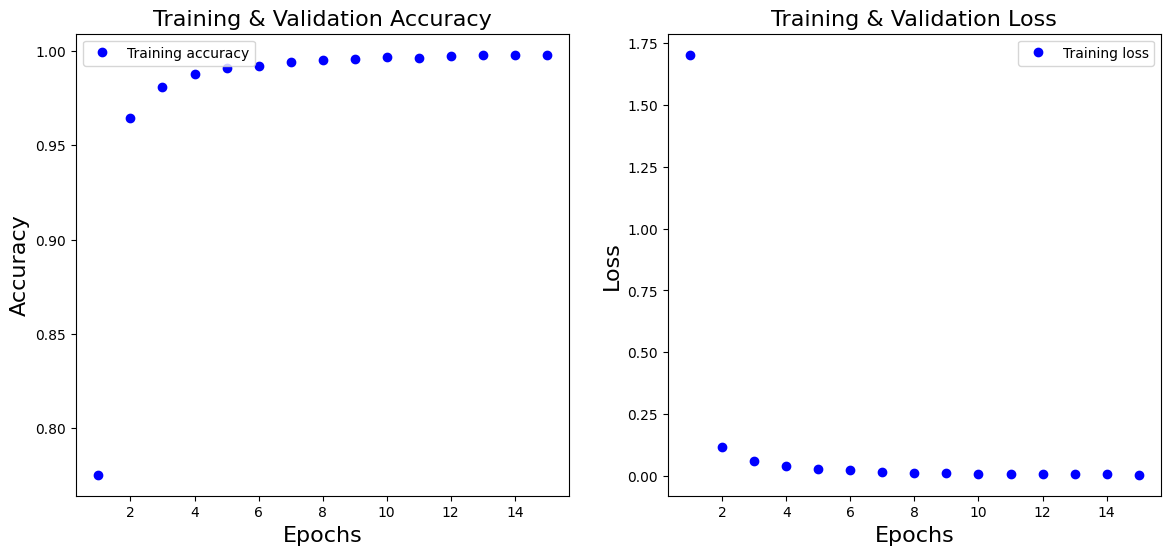

313/313 [==============================] - 3s 9ms/step - loss: 0.0578 - accuracy: 0.9906


2023-09-01 14:47:06.280 
  command:

    streamlit run C:\Users\ShaneShort\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


analyse training


In [6]:
test_loss, test_acc = analyse_history(model, history, x_test, y_test)
print('analyse training')

Testing model against individual images

1/1 [==============================] - 0s 207ms/step
Prediction: 8
True Label: 8


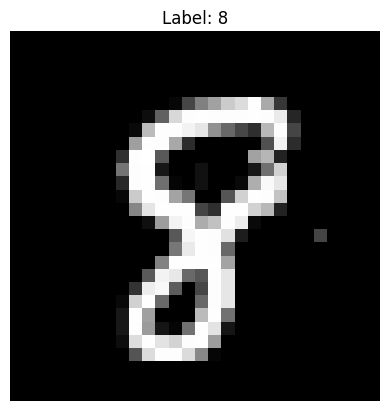

In [7]:
import matplotlib.pyplot as plt
import random

def _test_single(X_test, Y_test, image_index):
    image = X_test[image_index]  # Get the corresponding image data from X_test
    label = Y_test[image_index]  # Get the corresponding label data from y_test

    image = image.reshape(28, 28)  # Reshape the image array from (28, 28, 1) to (28, 28)

    plt.imshow(image, cmap='gray')  # Display the image using grayscale color map
    plt.title(f"Label: {np.argmax(label)}")  # Set the title of the plot with the true label
    plt.axis('off')  # Remove the axis labels

    return plt.gcf()  # Return the current figure for later plotting

image_index = random.randint(0, len(x_test)-1)  # Generate a random index within the range of the test set
label = y_test[image_index]  # Get the corresponding label data from y_test
prediction = model.predict(np.expand_dims(x_test[image_index], axis=0))
predicted_label = np.argmax(prediction)

print("Prediction:", predicted_label)
print("True Label:", np.argmax(label))

figure = _test_single(x_test, y_test, image_index)
plt.show()  # Show the plot


In [17]:
import tkinter as tk
from PIL import Image, ImageDraw
import io

In [18]:

window = tk.Tk()
canvas = tk.Canvas(window, width=280, height=280, bg='white')
canvas.pack()

In [19]:
def on_mouse_drag(event):
    x = event.x
    y = event.y
    radius = 5
    canvas.create_oval(x - radius, y - radius, x + radius, y + radius, fill='black')

canvas.bind('<B1-Motion>', on_mouse_drag)
def clear_canvas():
    canvas.delete('all')

def run_model_prediction():
    image = canvas.postscript(colormode='gray')
    img = Image.open(io.BytesIO(image.encode('utf-8')))
    img = img.resize((28, 28))
    # Process the image and feed it into your model for prediction
    prediction = model.predict(np.expand_dims(img, axis=0))
    predicted_label = np.argmax(prediction)

    print("Prediction:", predicted_label)


In [20]:
clear_button = tk.Button(window, text='Clear', command=clear_canvas)
clear_button.pack()

predict_button = tk.Button(window, text='Predict', command=run_model_prediction)
predict_button.pack()

window.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\ShaneShort\AppData\Local\Temp\ipykernel_9444\1246062621.py", line 14, in run_model_prediction
    img = img.resize((28, 28))
          ^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\PIL\Image.py", line 2157, in resize
    self.load()
  File "c:\Python311\Lib\site-packages\PIL\EpsImagePlugin.py", line 387, in load
    self.im = Ghostscript(self.tile, self.size, self.fp, scale, transparency)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\PIL\EpsImagePlugin.py", line 138, in Ghostscript
    raise OSError(msg)
OSError: Unable to locate Ghostscript on paths
